In [325]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [326]:
data = pd.read_csv("./data/ChatbotData .csv")

In [327]:
print(len(data))
data.head()

11823


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [328]:
question = [sentence for sentence in data["Q"]]
answer = [sentence for sentence in data["A"]]

In [329]:
#구두점 분리
#ㅋㅋㅋㅋㅋㅋㅋ, ㅎㅎㅎㅎㅎ, ㅠㅠㅠㅠㅠㅠ, ㅜㅜㅜ 두개로 통일
#!!!, ~~~~, ;;;; 하나로 통일
#큰따움표제거
#영어 소문자 변경

def preprocessing(sentences):
    s = []
    for sentence in sentences:
        temp = sentence.lower().strip()
        temp = re.sub("ㅋ+", " ㅋㅋ", temp)
        temp = re.sub("ㅎ+", " ㅎㅎ", temp)
        temp = re.sub("ㅜ+", " ㅜㅜ", temp)
        temp = re.sub("ㅠ+", " ㅠㅠ", temp)
        temp = re.sub(r"!+", "!", temp)
        temp = re.sub(r"~+", "~", temp)
        temp = re.sub(r";+", ";", temp)
        temp = re.sub(r"\"", "", temp)
        temp = re.sub(r"([.,!?~;])", r" \1", temp)
        s.append(temp)
    return s

In [330]:
print("하~~~~~;;;;;;;;;;오늘ㅋㅋㅋㅋㅋㅋㅋㅋㅎㅎㅎㅎㅎㅠ!!!!!!!!!!!!~~~~~")
print(" ".join(preprocessing(["하~~~~~;;;;;;;;;;오늘ㅋㅋㅋㅋㅋㅋㅋㅋㅎㅎㅎㅎㅎㅠ!!!!!!!!!!!!~~~~~"])))

하~~~~~;;;;;;;;;;오늘ㅋㅋㅋㅋㅋㅋㅋㅋㅎㅎㅎㅎㅎㅠ!!!!!!!!!!!!~~~~~
하 ~ ;오늘 ㅋㅋ ㅎㅎ ㅠㅠ ! ~


In [331]:
question = preprocessing(question)
answer = preprocessing(answer)

print(question[:10])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'ppl 심하네', 'sd카드 망가졌어', 'sd카드 안돼', 'sns 맞팔 왜 안하지 ㅠㅠ', 'sns 시간낭비인 거 아는데 매일 하는 중', 'sns 시간낭비인데 자꾸 보게됨']


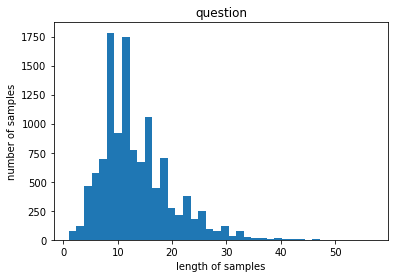

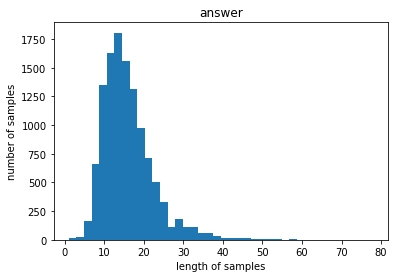

질문의 최소 길이 : 1
질문의 최대 길이 : 57
질문의 평균 길이 : 13.236319039160957
응답의 최소 길이 : 1
응답의 최대 길이 : 78
응답의 평균 길이 : 16.03603146409541


In [332]:
question_len = [len(s) for s in question]
answer_len = [len(s) for s in answer]

plt.title('question')
plt.hist(question_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('answer')
plt.hist(answer_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

print('질문의 최소 길이 : {}'.format(np.min(question_len)))
print('질문의 최대 길이 : {}'.format(np.max(question_len)))
print('질문의 평균 길이 : {}'.format(np.mean(question_len)))
print('응답의 최소 길이 : {}'.format(np.min(answer_len)))
print('응답의 최대 길이 : {}'.format(np.max(answer_len)))
print('응답의 평균 길이 : {}'.format(np.mean(answer_len)))

In [333]:
max_len = 40
min_len = 1

In [334]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(question + answer, target_vocab_size=2<<14)
print(tokenizer.vocab_size)

21824


In [335]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

VOCAB_SIZE = tokenizer.vocab_size + 2

START_TOKEN의 번호 : [21824]
END_TOKEN의 번호 : [21825]


In [336]:
encoder_input = []
decoder_input = []
decoder_output = []

for (encoder_data, decoder_data) in zip(question, answer):
    if (len(encoder_data) > min_len and len(encoder_data) <= max_len) and (len(decoder_data) > min_len and len(decoder_data) <= max_len):
        encoder_input.append(START_TOKEN + tokenizer.encode(encoder_data) + END_TOKEN)
        decoder_input.append(START_TOKEN + tokenizer.encode(decoder_data) + END_TOKEN)
        decoder_output.append(tokenizer.encode(decoder_data) + END_TOKEN)
        
encoder_input = tf.keras.preprocessing.sequence.pad_sequences(encoder_input, maxlen=max_len, padding="post")
decoder_input = tf.keras.preprocessing.sequence.pad_sequences(decoder_input, maxlen=max_len-1, padding="post")
decoder_output = tf.keras.preprocessing.sequence.pad_sequences(decoder_output, maxlen=max_len-1, padding="post")


In [337]:
BATCH_SIZE = 256
BUFFER_SIZE = 11823

dataset = tf.data.Dataset.from_tensor_slices(((encoder_input, decoder_input), decoder_output))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [338]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

        
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
                                     i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
                                     d_model=d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
    
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [339]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)
    return output

In [340]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        outputs = self.dense(concat_attention)

        return outputs

In [341]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [342]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
    })

    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [343]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(units=units,
                                d_model=d_model, 
                                num_heads=num_heads,
                                dropout=dropout,
                                name="encoder_layer_{}".format(i),)([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [344]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={'query': inputs,
                                                                                    'key': inputs,
                                                                                    'value': inputs, 
                                                                                    'mask': look_ahead_mask})

    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={'query': attention1,
                                                                                    'key': enc_outputs,
                                                                                    'value': enc_outputs,
                                                                                    'mask': padding_mask})

    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                          outputs=outputs,
                          name=name)

In [345]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(units=units,
                                d_model=d_model,
                                num_heads=num_heads,
                                dropout=dropout,
                                name='decoder_layer_{}'.format(i),)(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                          outputs=outputs,
                          name=name)

In [346]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, 
                                              output_shape=(1, 1, None), 
                                              name='enc_padding_mask')(inputs)

    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask,
                                             output_shape=(1, None, None),
                                             name='look_ahead_mask')(dec_inputs)

    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, 
                                              output_shape=(1, 1, None),
                                              name='dec_padding_mask')(inputs)

    enc_outputs = encoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads=num_heads,
                          dropout=dropout,)(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads=num_heads,
                          dropout=dropout,)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])


    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [347]:
tf.keras.backend.clear_session()

NUM_LAYERS = 4
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.2

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    7695872     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [348]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, max_len-1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [349]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
sample_learning_rate = CustomSchedule(d_model=128)

In [350]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, max_len-1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [351]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
46/46 [==============================] - 28s 384ms/step - loss: 1.4338 - accuracy: 0.0055
Epoch 2/100
46/46 [==============================] - 17s 377ms/step - loss: 1.3752 - accuracy: 0.0260
Epoch 3/100
46/46 [==============================] - 17s 370ms/step - loss: 1.3231 - accuracy: 0.0258
Epoch 4/100
46/46 [==============================] - 17s 369ms/step - loss: 1.2627 - accuracy: 0.0257
Epoch 5/100
46/46 [==============================] - 17s 373ms/step - loss: 1.1847 - accuracy: 0.0396
Epoch 6/100
46/46 [==============================] - 17s 374ms/step - loss: 1.0983 - accuracy: 0.0494
Epoch 7/100
46/46 [==============================] - 17s 372ms/step - loss: 1.0179 - accuracy: 0.0498
Epoch 8/100
46/46 [==============================] - 17s 371ms/step - loss: 0.9453 - accuracy: 0.0500
Epoch 9/100
46/46 [==============================] - 17s 372ms/step - loss: 0.8848 - accuracy: 0.0500
Epoch 10/100
46/46 [==============================] - 17s 372ms/step - loss: 0.835

46/46 [==============================] - 17s 373ms/step - loss: 0.0098 - accuracy: 0.1422
Epoch 81/100
46/46 [==============================] - 17s 373ms/step - loss: 0.0098 - accuracy: 0.1422
Epoch 82/100
46/46 [==============================] - 17s 373ms/step - loss: 0.0096 - accuracy: 0.1422
Epoch 83/100
46/46 [==============================] - 17s 372ms/step - loss: 0.0098 - accuracy: 0.1422
Epoch 84/100
46/46 [==============================] - 17s 373ms/step - loss: 0.0093 - accuracy: 0.1423
Epoch 85/100
46/46 [==============================] - 17s 373ms/step - loss: 0.0097 - accuracy: 0.1422
Epoch 86/100
46/46 [==============================] - 17s 373ms/step - loss: 0.0098 - accuracy: 0.1421
Epoch 87/100
46/46 [==============================] - 17s 373ms/step - loss: 0.0100 - accuracy: 0.1420
Epoch 88/100
46/46 [==============================] - 17s 373ms/step - loss: 0.0091 - accuracy: 0.1423
Epoch 89/100
46/46 [==============================] - 17s 373ms/step - loss: 0.0088 - 

In [352]:
def decoder_inference(sentence):
    sentence = preprocessing([sentence])
    sentence = tokenizer.encode(sentence[0])
    sentence = tf.expand_dims(START_TOKEN+sentence+END_TOKEN, axis=0)
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    for i in range(max_len):
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [353]:
def sentence_generation(sentence):
    prediction = decoder_inference(sentence)

    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [364]:
print(sentence_generation("심심해요"))

입력 : 심심해요
출력 : 저랑 놀아요 .
저랑 놀아요 .


In [355]:
print(sentence_generation("안녕하세요?"))

입력 : 안녕하세요?
출력 : 안녕하세요 .
안녕하세요 .


In [358]:
print(sentence_generation("잘 지내?"))

입력 : 잘 지내?
출력 : 당신은 잘 지내고 있나봅니다 .
당신은 잘 지내고 있나봅니다 .


In [357]:
print(sentence_generation("날씨 개좋음"))

입력 : 날씨 개좋음
출력 : 모두를 위한 결심인지 확인해보세요 .
모두를 위한 결심인지 확인해보세요 .


In [359]:
print(sentence_generation("배고프다~~~~"))

입력 : 배고프다~~~~
출력 : 저도 밥 먹고 싶어요
저도 밥 먹고 싶어요
